## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_cols(df, cols):
    return df[cols].T.values

def get_column_names(s, df):
    cols = df.columns.tolist()
    return list(filter(lambda x: x.startswith(s), cols))

In [3]:
def get_classification_duration(metadata):
    start = metadata.get('started_at')
    end = metadata.get('finished_at')
    timedelta = pd.Timestamp(end) - pd.Timestamp(start)
    return timedelta.total_seconds()

In [4]:
lightblue = 'xkcd:lightish blue'

In [5]:
# dataframe .json files are created in ./df_stacked.ipynb. 
#  Make sure to re-run that notebook whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('df_votes.json')
df = pd.read_json('df_stacked.json')

In [6]:
df['duration'] = df['metadata'].apply(lambda x: get_classification_duration(x))

## Analysis

In [7]:
groupby_user = df.groupby('user_name')

## no. of  classifications per user:

In [8]:
clas_per_user = groupby_user.agg('count')['Filename'].tolist()

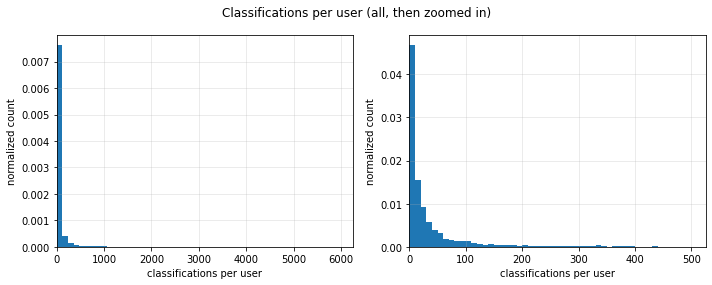

In [9]:
fig, fr = plt.subplots(1,2, figsize=(10,4))

kwargs = { "density": True, "bins": 50}

fr[0].hist(clas_per_user, **kwargs)
fr[1].hist(clas_per_user, **kwargs, range=[0,500])

for i in range(2):
    fr[i].set_ylabel('normalized count')
    fr[i].set_xlabel('classifications per user')
    fr[i].grid(alpha=0.3)
    fr[i].set_xlim(0)
    
fig.suptitle('Classifications per user (all, then zoomed in)')
fig.tight_layout()
plt.show()

## classification duration:

Plot histogram of classification durations (1) per classification, (2) per user, (3) per object.
Note that in reality, the tail of the distribution extends to ~1e5 for the per-classification and per-user cases, because there are some classifications that lasted over a day, presumably because someone simply left the page open and then finished the classification the next day.

In [47]:
df['created_at'].iloc[[0, -1]]

0        2020-10-20 04:25:18
223058   2021-01-12 13:04:36
Name: created_at, dtype: datetime64[ns]

## Duration per workflow

In [46]:
for workflow in df.workflow_name.unique():
    print(workflow, df.query('workflow_name == @workflow & duration <= 3600')['duration'].agg(['mean', 'median']).values)

Classify! Hardcore edition [40.8337982 14.908    ]
Classify! [19.82888731  5.765     ]
Classify on the go! [11.1668402  3.01     ]


## Duration per user, etc.

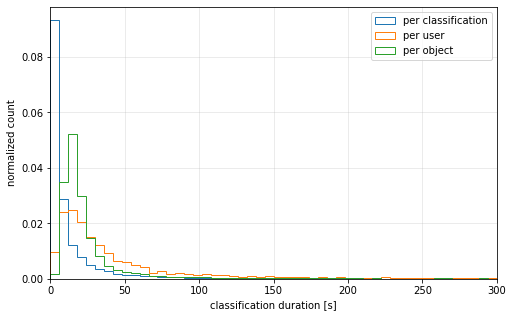

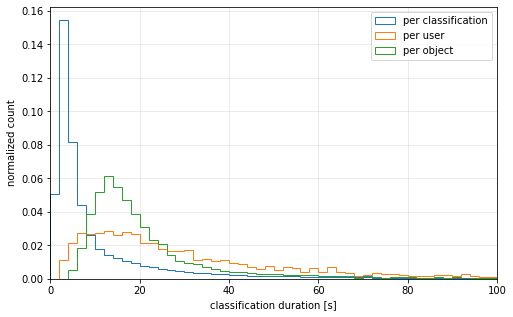

In [10]:
mean_duration_per_user = df[['user_name', 'duration']].groupby('user_name').agg('mean')['duration']

for displayrange in [[0,300], [0,100]]:
    fig, fr = plt.subplots(figsize=(8,5))

    kw = { "range": displayrange, "density": True, "histtype": "step", "bins": 50 }

    fr.hist(df['duration'], **kw, label='per classification')
    fr.hist(mean_duration_per_user, **kw, label='per user')
    fr.hist(df[['Filename', 'duration']].groupby('Filename').agg('mean')['duration'], **kw, label='per object')

    fr.set_xlim(displayrange)
    fr.grid(alpha=0.3)
    fr.set_xlabel('classification duration [s]')
    fr.set_ylabel('normalized count')
    fr.legend()
    plt.show()

## Find a way to compare user performance to their peers:

In [11]:
tasks_hardcore = sorted([0, 2, 1, 3, 4, 5, 9])
task_strings = ['T{}'.format(t) for t in tasks_hardcore]

In [12]:
task_cols_list = [get_column_names(t, df_votes) for t in task_strings]

In [13]:
def get_consensus(row, task):
    '''
    @param row: a row in a df_votes-type dataframe
    @param task: one of the tasks in a workflow, e.g. 'T0'
    '''
    votes = row[task]
    
    vals = np.array(list(votes.values()))
    keys = np.array(list(votes.keys()))

    if len(vals) > 0:
        consensus = list(keys[np.where(vals == np.max(vals))])
        return consensus    

#### Create consensus column for every task, assigning the most common answer for that task, for every object.

##### First create the dataframe columns:

In [14]:
for task in task_strings:
    df_votes['{} consensus'.format(task)] = df_votes.apply(lambda x: get_consensus(x, task), axis=1)

##### Then loop over every column and put results in a list of hash tables, one hash table per task:

In [15]:
consensus_per_task = []

for task in task_strings:
    names, consensus = df_votes[['name', '{} consensus'.format(task)]].values.T
    task_consensus = {n: c for n, c in zip(names, consensus)}
    
    consensus_per_task.append(task_consensus)

In [16]:
def with_consensus_bool(i, row, task):
    '''
    Returns bool | None based on whether the user's vote
        for a given object, for the given task,
        matches the consensus among all users 
        (where the consensus already includes this user's vote)
    @todo: consider whether we should first compute consensus WITHOUT this user, 
        and then check if the user matches that consensus,
        otherwise this evaluates to True if only one vote was brought out 
        for an object, for a given task, namely the vote by this user                
                
    @param i (int) index in task_strings
    @param row row in df_votes-type dataframe
    @task (str) one of 'T0', ..., 'T9'
    '''
    val = row[task]
    name = row['Filename']
    
    if isinstance(consensus_per_task[i][name], list) and (not val == None):
        return val in consensus_per_task[i][name]
    
    return None

In [17]:
for i, task in enumerate(task_strings):
    df['with consensus {}'.format(task)] = df[['Filename', task]].apply(lambda x: with_consensus_bool(i, x, task) , axis=1)

In [18]:
groupby_user = df[['user_name', 'Filename', 'with consensus T0']].groupby('user_name')

_Note: I'm calling it accuracy in some places, but it's just consensus/precision among peers_

In [19]:
def get_task_user_accuracy(task):
    '''
    Returns tuple (actually, two lists with same-index corresponding to a tuple)
     of classifications made per user and the accuracy per user among their peers,
     for the specified task.
     
    @param task (str) one of 'T0', ..., 'T9'
    '''    
    
    groupby_user = df[['user_name', 'Filename', 'with consensus {}'.format(task)]].groupby('user_name')
    
    user_accuracy = {}

    for name, group in groupby_user:
        cons = group['with consensus {}'.format(task)].values.tolist()
        true_count = cons.count(True)
        false_count = cons.count(False)

        if true_count + false_count > 0:
            task_count = true_count+false_count
            precision = true_count/(true_count+false_count)  # there are also None entries, where nobody (including this user) 
                                                             # ended up at a given task for a given object. don't count those rows, obviously
        else: 
            task_count = 0
            precision = -1
        user_accuracy[name] = { "accuracy": precision, "votes": len(cons), "task_count": task_count}
        
    vote_count, accuracy, task_count = np.array([(v['votes'], v['accuracy'], v['task_count']) for v in list(user_accuracy.values())]).T
    
    idc = np.where(accuracy > -1)
    return vote_count[idc], accuracy[idc], task_count[idc]

## Plot votes per user vs. consensus (precision) among peers:

Three adjacent plots per task;
- histogram of precision
- plot classifications per user vs. precision, with classifications in log_10 scale.
- plot classifications per user vs. precision, with classifications in linear scale, with xlim from 0 to 500 for readability (log scale already includes _all_ users, so this doesn't hide any data).

The colormap on the scatter plots indicates (in log_10) scale, the number of votes the user made _for that specific task_. We see from the colorbar that every single user did 'T0', but beyond that, things start to diverge. 
This is simply due to the fact that not every classification contains all the tasks, so if a user never encounters an object they believe to be 'empty', they'll never be asked T9, for example.

In [22]:
def plot_user_precision(task, plot_total_votes=True):
    vote_count, accuracy, task_count = get_task_user_accuracy(task)
    c_map = np.log(task_count)/np.log(10)

    xlabel = '{} classifications by user'.format(task)
   
    fig, fr = plt.subplots(1,3, figsize=(15,3.5), gridspec_kw={"wspace": 0.2, "width_ratios": [6,12,10]})

    kw = { "s": 4, "cmap": 'jet_r' }
    
    sc = fr[1].scatter(vote_count, accuracy, alpha=0.6, **kw, c=c_map) 
    fr[2].scatter(task_count, accuracy, alpha=0.4, **kw, c=lightblue) 

    fr[1].set_xscale('log')
    fig.colorbar(sc, ax=fr[1])
    
    fr[1].update(dict(
        xlim=[0.9, max(vote_count)+1000],
        ylim=(0),
        xlabel="Total classifications",
        ylabel="Precision among peers"
    ))
        
    fr[2].update(dict(
        ylim=(0),
        xlim=(0.9),
        ylabel='Precision among peers',
        xlabel="{} classifications".format(task)
    ))
        
    fr[0].hist(accuracy, color=lightblue, bins=20)
    fr[0].update({
        "xlim": [0,1],
        "xlabel": 'Precision among peers',
        "ylabel": '# users'
    })

    titles = [
        'User precision histogram',
        'Classification count vs. precision (log)',
        'Classification count vs. precision (linear)'
    ]

    for i in range(3):
        fr[i].set_title(titles[i])
        fr[i].grid(alpha=0.2, which='both')
        
    fig.suptitle('{}'.format(task), fontsize=15, bbox=dict(facecolor='white', edgecolor='black', pad=0.6, boxstyle='Square'), x=0.615, y=0.92)

#     plt.savefig('user-precision-{}'.format(task), dpi=200, bbox_inches='tight')
    plt.show()

#### With how I've set up the above function, we can plot two ways:
- plot total classifications per user on x-axis, color by number of classifications for the given task
- plot only classifications for the given task on the x-axis

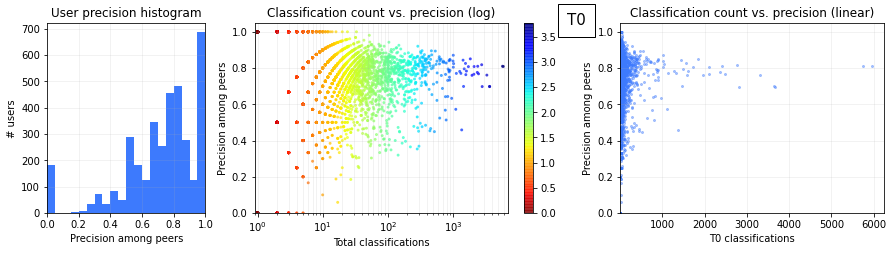

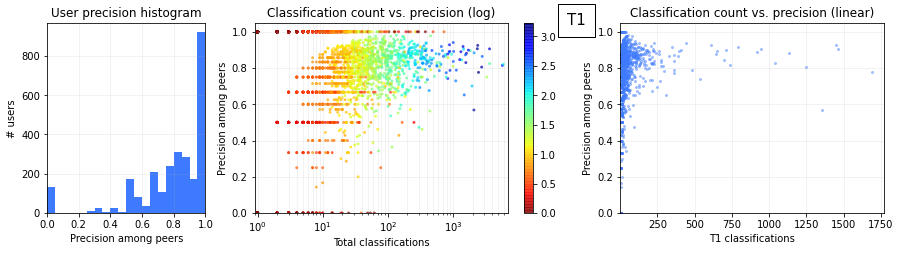

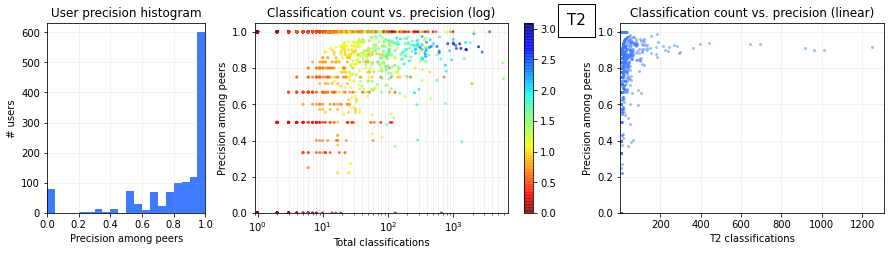

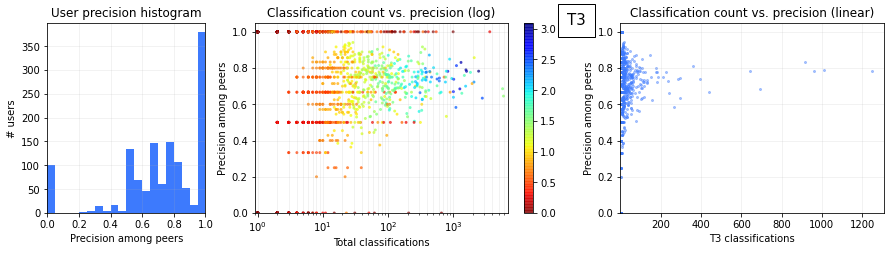

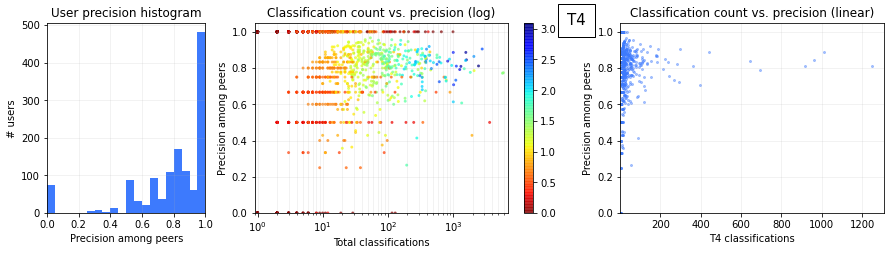

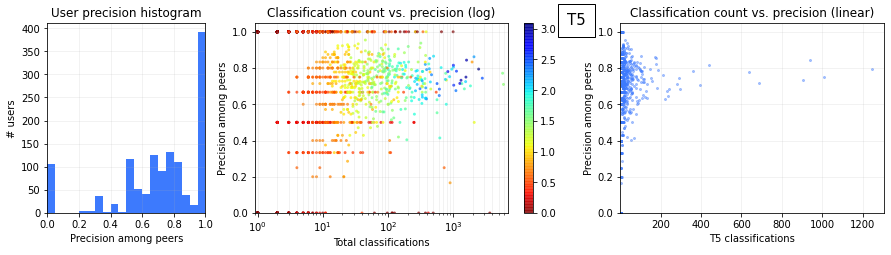

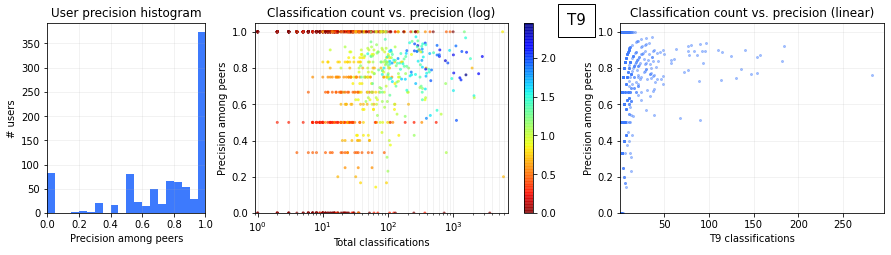

In [23]:
for task in task_strings[:]:
    plot_user_precision(task, plot_total_votes=False)
#     plot_user_precision(task, plot_total_votes=True)